In [1]:
import os
import shutil
import json
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

current_directory = os.getcwd()
path_components = current_directory.split(os.path.sep)
new_directory = os.path.sep.join(path_components[:-1])
sys.path.append(new_directory)


## Post processing framework

#### Simulation Name

In [2]:
simulation_name = 'Main_BornIon'
simulation_folder = 'tests'

results_dir = os.path.sep.join(path_components[:-2])
results_path = os.path.join(results_dir,'.results',simulation_folder,simulation_name)
main_path = os.path.join(results_dir,'code')
shutil.copyfile(os.path.join(results_path,simulation_name+'.py'), os.path.join(main_path,'S_temp.py'))
print(main_path)
print(results_path)

/home/martinachondo/PINN/code
/home/martinachondo/PINN/.results/tests/Main_BornIon


In [3]:
folder_name = 'S_temp'
folder_path = os.path.join(main_path,'results',folder_name)

from S_temp import PDE

sim = PDE()
N_points = {'hmin_interior': 1.0,
            'hmin_exterior': 1.0,
            'density_mol': 40,
            'density_border': 4,
            'dx_experimental': 2,
            'N_pq': 100,
            'G_sigma': 0.04,
            'mesh_generator': 'msms',
            'dR_exterior': 2
                }
for key,value in N_points.items():
    sim.N_points[key] = value
print(sim.inputs)
sim.create_simulation()

XPINN_solver = sim.XPINN_solver

OpenMesh not available
No module named 'openmesh'
{'molecule': 'born_ion', 'epsilon_1': 1, 'epsilon_2': 80, 'kappa': 0.125, 'T': 300}
/home/martinachondo/PINN/code/Mesh/Mesh_softwares/MSMS/msms -if /home/martinachondo/PINN/code/Molecules/born_ion/born_ion.xyzr -of /home/martinachondo/PINN/code/Molecules/Saved_meshes/Temp/born_ion_d40 -p 1.4 -d 40 -no_header
MSMS 2.6.1 started on tulio
Copyright M.F. Sanner (1994)
Compilation flags -O2 -DVERBOSE -DTIMING
Atom 2 ignored, radius = 0.010000
INPUT  /home/martinachondo/PINN/code/Molecules/born_ion/born_ion.xyzr 1 spheres 0 collision only, radii  1.000 to  1.000
PARAM  Probe_radius  1.400 density 40.000 hdensity  3.000
REDUCED SURFACE ...
    1 free vertex (vertices) found
    RS component  #faces  #edges #free_edges  #vertices   genus
         0           0        1          0          1      1
    Time Reduced Surface real: 0.00 user: 0.00 sys: 0.00
ANALYTICAL SOLVENT EXCLUDED SURFACE...
    Component   0
        Time Surface real: 0.00 use

In [4]:
Iter = 6
from NN.NeuralNet import XPINN_NeuralNet
XPINN_solver.folder_path = folder_path
XPINN_solver.load_NeuralNet(XPINN_NeuralNet,results_path,f'iter_{Iter}')
XPINN_solver.N_iters = XPINN_solver.iter

In [5]:
from Post.Postcode import Born_Ion_Postprocessing as Postprocessing
Post = Postprocessing(XPINN_solver, save=True, directory=folder_path)

In [6]:
df = Post.save_values_file(save=False)
print(json.dumps(df, indent=4))

{
    "Gsolv_value": "0.000",
    "L2_continuity_u": "4.281e-01",
    "L2_continuity_du": "1.229e-01",
    "Loss_XPINN": "9.403e+04",
    "Loss_NN1": "9.403e+04",
    "Loss_NN2": "2.371e-01",
    "L2_analytic": "2.328e+02"
}


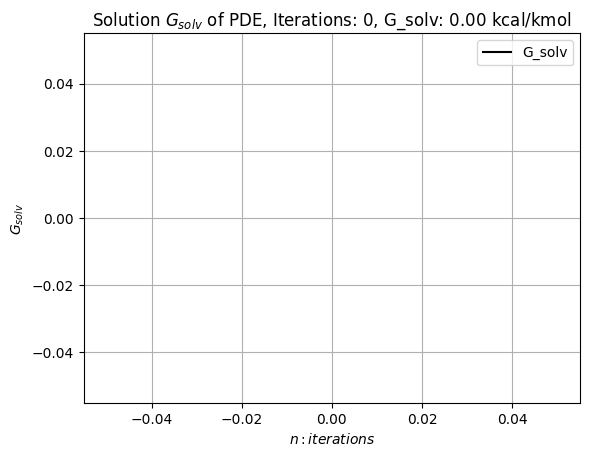

In [20]:
Post.plot_G_solv_history()

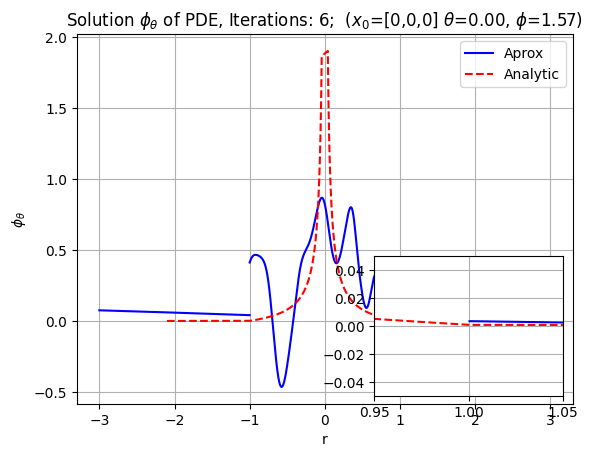

In [21]:
Post.plot_aprox_analytic(N=8000,zoom=True, lims_zoom=[[0.95,1.05],None])

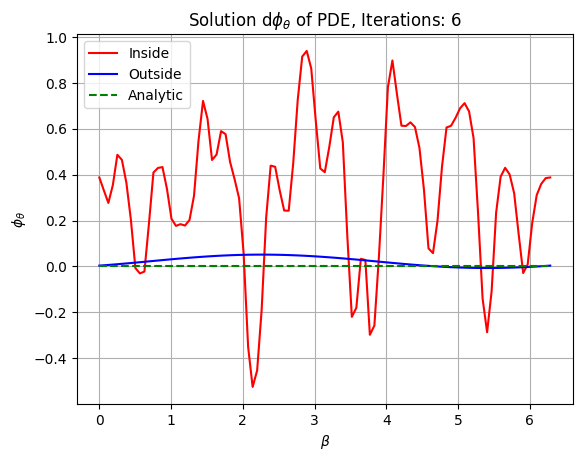

In [22]:
Post.plot_line_interface()

In [23]:
Post.plot_mesh_3D()
Post.plot_interface_3D('phi')
Post.plot_interface_3D('dphi')

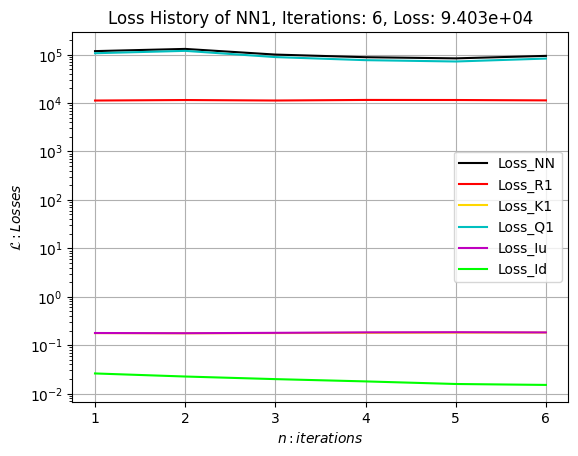

In [24]:
Post.plot_loss_history(domain=1)

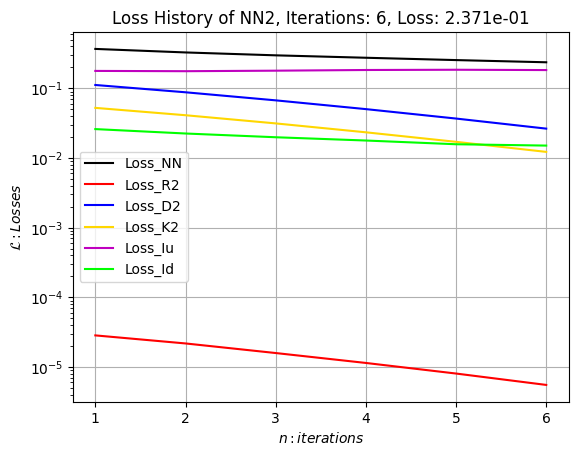

In [25]:
Post.plot_loss_history(domain=2)

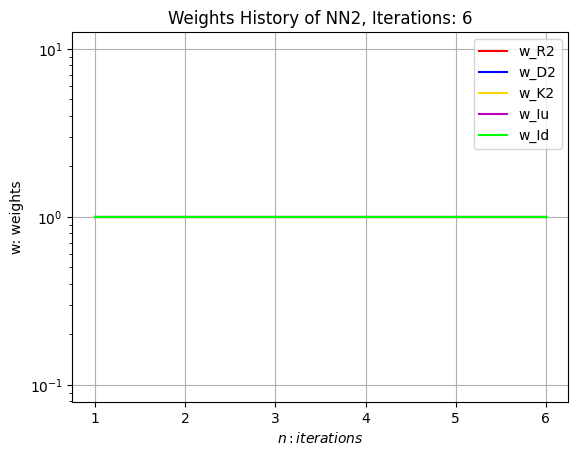

In [26]:
Post.plot_weights_history(domain=2)

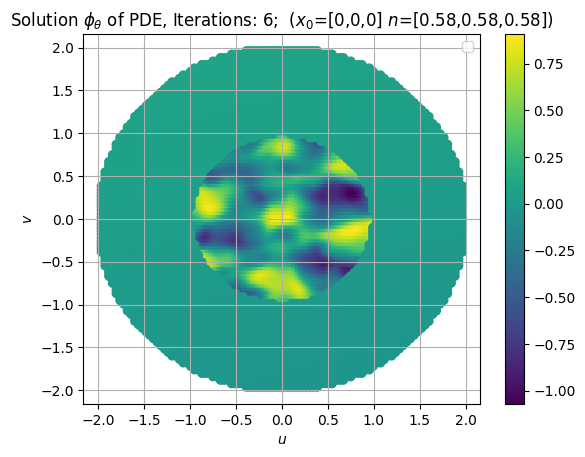

In [27]:
Post.plot_phi_contour(n=np.array([1,1,1]))

In [6]:
Post.plot_vol_mesh_3D(jupyter=True)

ERROR getVolume(): Orientation undefined for one or more simplices. Did you call compute_orientation()?
ERROR getVolume(): Orientation undefined for one or more simplices. Did you call compute_orientation()?


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(…

#### Aditional computations

In [14]:
import bempp.api

u_interface,_,_ = Post.PDE.get_phi_interface(*Post.NN)
u_interface = u_interface.flatten()
_,du_1,du_2 = Post.PDE.get_dphi_interface(*Post.NN)
du_1 = du_1.flatten()
du_2 = du_2.flatten()
du_1_interface = (du_1+du_2*Post.NN[1].PDE.epsilon/Post.NN[0].PDE.epsilon)/2

phi = bempp.api.GridFunction(Post.PDE.space, coefficients=u_interface)
dphi = bempp.api.GridFunction(Post.PDE.space, coefficients=du_1_interface)

phi_q = Post.PDE.slp_q * dphi - Post.PDE.dlp_q * phi

slp_aprox = Post.PDE.slp_q * dphi
dlp_aprox = Post.PDE.dlp_q * phi

In [15]:
print('slp',slp_aprox)
print('dlp', dlp_aprox)

slp [[-0.04577357]]
dlp [[-0.00114817]]


In [16]:
Rs = np.linalg.norm(Post.PDE.mesh.mol_verts, axis=1)

u_interface = Post.PDE.analytic_Born_Ion(Rs)
du_1_interface = Post.PDE.analytic_Born_Ion_du(Rs)

phi = bempp.api.GridFunction(Post.PDE.space, coefficients=u_interface)
dphi = bempp.api.GridFunction(Post.PDE.space, coefficients=du_1_interface)

slp_an = Post.PDE.slp_q * dphi
dlp_an = Post.PDE.dlp_q * phi

In [17]:
print('slp',slp_an)
print('dlp', dlp_an)

slp [[-0.07938546]]
dlp [[-0.00094506]]


In [18]:
def get_Gsolv(slp,dlp):
  phi_q = slp - dlp
  G_solv = 0.5*np.sum(Post.PDE.qs * phi_q).real
  G_solv *= Post.PDE.to_V*Post.PDE.qe*Post.PDE.Na*(10**-3/4.184) 
  return G_solv

In [19]:
print('aprox',get_Gsolv(slp_aprox,dlp_aprox))
print('an',get_Gsolv(slp_an,dlp_an))

aprox -93.10722575405698
an -163.65945134158008


In [20]:
print('ap-an',get_Gsolv(slp_aprox,dlp_an))
print('an-ap',get_Gsolv(slp_an,dlp_aprox))

ap-an -93.53099959788352
an-ap -163.23567749775356
